In [134]:
import numpy as np
import matplotlib.pyplot as plt

In [129]:
def cal_snr(
        N_star: float,  
        N_sky: float, 
        N_dark: float, 
        N_read: float, 
):
    """
    Calculate the SNR of a spectrum.
    
    Parameters
    ----------
    N_star : float
        Number of photons from the star.
    N_sky : float
        Number of photons from the sky.
    N_dark : float
        Number of photons from the dark current.
    N_read : float
        Number of photons from the read noise.
        
    Returns
    -------
    snr : float
        SNR of the spectrum.
    """
    snr = N_star / np.sqrt(N_star + (N_sky + N_dark + N_read**2))
    return snr

def cal_flux(mag, k, eff):
    return 10**(-0.4 * (mag - 8.9 + k)) * eff * 1e-26

In [130]:
app = 0.36  # arcsec^2 per pixel

seeing = 1.5  # arcsec
psf_area = np.pi * (seeing / 2)**2  # arcsec^2

pix_scale = 0.6  # arcsec/pixel
pix_size = 10e-6  # meter/pixel
psf_area_meter = psf_area * (pix_scale * pix_size)**2  # meter^2

n_pix = psf_area / app  # number of pixels

mag_star = 15  # magnitude
mag_background = 21  # magnitude
kV = 0.35 * 1.2  # magnitude

eff = 0.4  # efficiency of telescope

F_star = cal_flux(mag_star, kV, eff)
F_background = cal_flux(mag_background, kV, eff)

quantum eff

In [131]:
wavelength_arr = np.array([350e-9, 400e-9, 500e-9, 650e-9, 900e-9])
qe_arr = np.array([0.3, 0.75, 0.75, 0.8, 0.5])
# 线性插值量子效率
func_qe = lambda l: np.interp(l, wavelength_arr, qe_arr)

def cal_avg_qe(center_wavelength, band_waveth):
    """
    Calculate the average quantum efficiency.
    
    Parameters
    ----------
    center_wavelength : float
        Center wavelength of the band.
    band_waveth : float
        Bandwidth.
        
    Returns
    -------
    avg_qe : float
        Average quantum efficiency.
    """
    wavelength_arr = np.arange(center_wavelength - band_waveth / 2, center_wavelength + band_waveth / 2, 0.1)
    qe_arr = func_qe(wavelength_arr)
    avg_qe = np.sum(qe_arr) / len(qe_arr)
    return avg_qe

In [132]:
wavelength = 550e-9
band_width = 100e-9
band_width_nu = np.abs(3e8 / (wavelength - band_width / 2) - 3e8 / (wavelength + band_width / 2))

h = 6.626e-34  # J*s
energy_per_photon = h * 3e8 / (wavelength)  # J

F_count_star = F_star * band_width_nu * psf_area_meter
F_count_background = F_background * band_width_nu * psf_area_meter

t_exp = 20  # seconds

qe_avg_on_band = cal_avg_qe(wavelength, band_width)
N_star = F_count_star * qe_avg_on_band / energy_per_photon * t_exp
N_background = F_count_background * qe_avg_on_band / energy_per_photon * t_exp

eff_dark = 4    # e-/pix/s
N_eff = eff_dark * t_exp * n_pix

eff_rd = 4  # e-/pix
N_rd = eff_rd * np.sqrt(n_pix)

In [133]:
snr = cal_snr(N_star, N_background, N_eff, N_rd)
snr

1.1997633413579915e-28

In [101]:
def func_snr(mag_star):
    app = 0.36  # arcsex^2 per pixel

    seeing = 1.5  # arcsec
    psf_area = np.pi * (seeing / 2)**2  # arcsec^2

    pix_scale = 0.6  # arcsec/pixel
    pix_size = 10e-6  # meter/pixel
    psf_area_meter = psf_area * (pix_scale * pix_size)**2  # meter^2

    n_pix = psf_area / app  # number of pixels

    # mag_star = 16  # magnitude
    mag_background = 21  # magnitude
    kV = 0.35 * 1.2  # magnitude

    eff = 0.4  # efficiency of telescope

    erg = 1e-7  # erg

    F_star = cal_flux(mag_star, kV, eff) * erg *   # erg/s/cm^2
    F_background = cal_flux(mag_background, kV, eff) * erg

    wavelength_arr = np.array([350, 400, 500, 650, 900])
    qe_arr = np.array([0.3, 0.75, 0.75, 0.8, 0.5])
    # 线性插值量子效率
    func_qe = lambda l: np.interp(l, wavelength_arr, qe_arr)
    # func_qe = np.vectorize(func_qe)
    
    wavelength = 550
    band_width = 200

    h = 6.626e-34  # J*s
    energy_per_photon = h * 3e8 / (wavelength * 1e-9)  # J

    F_count_star = F_star * band_width * 1e-9 * psf_area_meter
    F_count_background = F_background * band_width * 1e-9 * psf_area_meter

    t_exp = 20  # seconds

    qe_avg_on_band = cal_avg_qe(wavelength, band_width)
    N_star = F_count_star * qe_avg_on_band / energy_per_photon * t_exp
    N_background = F_count_background * qe_avg_on_band / energy_per_photon * t_exp


    eff_dark = 4    # e-/pix/s
    N_eff = eff_dark * t_exp * n_pix

    eff_rd = 4  # e-/pix
    N_rd = eff_rd * n_pix

    return cal_snr(N_star, N_background, N_eff, N_rd)

SyntaxError: invalid syntax (3679583053.py, line 21)

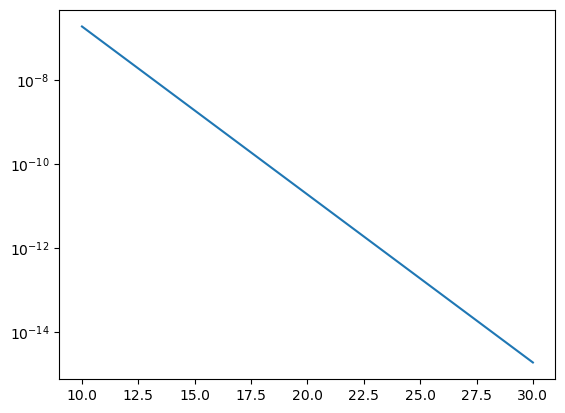

In [68]:
mag_arr = np.linspace(10, 30, 100)
snr_arr = np.array([func_snr(mag) for mag in mag_arr])

plt.semilogy(mag_arr, snr_arr)